### 首先导入数据


In [ ]:
import numpy as np


class NumpyOp:
    
    def __init__(self):
        self.memory = {}
        self.epsilon = 1e-12


class Matmul(NumpyOp):
    
    def forward(self, x, W):
        """
        x: shape(N, d)
        w: shape(d, d')
        """
        self.memory['x'] = x
        self.memory['W'] = W
        h = np.matmul(x, W)
        return h
    
    def backward(self, grad_y):
        """
        grad_y: shape(N, d')
        """
        
        x, W= self.memory['x'], self.memory['W']
        grad_x=np.matmul(grad_y, W.T)
        grad_W=np.matmul(x.T, grad_y)
        
        return grad_x, grad_W


class Relu(NumpyOp):
    
    def forward(self, x):
        self.memory['x'] = x
        return np.where(x > 0, x, np.zeros_like(x))
    
    def backward(self, grad_y):
        """
        grad_y: same shape as x
        """
        x=self.memory['x']
        grad_x= grad_y*np.where(x>0, np.ones_like(x), np.zeros_like(x))
        
        return grad_x


class Log(NumpyOp):
    
    def forward(self, x):
        """
        x: shape(N, c)
        """
  
        out = np.log(x + self.epsilon)
        self.memory['x'] = x
        
        return out
    
    def backward(self, grad_y):
        """
        grad_y: same shape as x
        """
        x=self.memory['x']
        grad_x=grad_y* np.reciprocal(x+self.epsilon)
        
        return grad_x


class Softmax(NumpyOp):
    """
    softmax over last dimension
    """
    
    def forward(self, x):
        """
        x: shape(N, c)
        """
        self.memory['x']=x
        exp_x=np.exp(x-np.max(x,axis=1,keepdims=True))
        out=exp_x/np.sum(exp,axis=1,keepdims=True)
        self.memory['out']=out
        
        return out
    
    def backward(self, grad_y):
        """
        grad_y: same shape as x
        """
        y=self.memory['out']
        Jaco = np.array([np.diag(r)-np.outer(r,r) for r in y])

        grad_y=grad_y[:, np.newaxis, : ]
        grad_x=np.matmul(grad_y, Jaco).squeeze(axis=1)

        return grad_x


class NumpyLoss:
    
    def __init__(self):
        self.target = None
    
    def get_loss(self, pred, target):
        self.target = target
        return (-pred * target).sum(axis=1).mean()
    
    def backward(self):
        return -self.target / self.target.shape[0]


class NumpyModel:
    def __init__(self):
        self.W1 = np.random.normal(size=(28 * 28, 256))
        self.W2 = np.random.normal(size=(256, 64))
        self.W3 = np.random.normal(size=(64, 10))
        
        # 以下算子会在 forward 和 backward 中使用
        self.matmul_1 = Matmul()
        self.relu_1 = Relu()
        self.matmul_2 = Matmul()
        self.relu_2 = Relu()
        self.matmul_3 = Matmul()
        self.softmax = Softmax()
        self.log = Log()
        
        # 以下变量需要在 backward 中更新。 softmax_grad, log_grad 等为算子反向传播的梯度（ loss 关于算子输入的偏导）
        self.x1_grad, self.W1_grad = None, None
        self.relu_1_grad = None
        self.x2_grad, self.W2_grad = None, None
        self.relu_2_grad = None
        self.x3_grad, self.W3_grad = None, None
        self.softmax_grad = None
        self.log_grad = None
    
    def forward(self, x):
        x = x.reshape(-1, 28 * 28)
        
        z1 = self.matmul_1.forward(x, self.W1)
        x2 = self.relu_1.forward(z1)
        z2 = self.matmul_2.forward(x2, self.W2)
        x3 = self.relu_2.forward(z2)
        z3 = self.matmul_3.forward(x3, self.W3)
        out = self.softmax.forward(z3)
        x = self.log.forward(out)
        

        return x
    
    def backward(self, y):
        self.log_grad = self.log.backward(y)   
        self.softmax_grad = self.softmax.backward(self.log_grad)
        self.x3_grad, self.W3_grad = self.matmul_3.backward(self.softmax_grad)
        self.relu_2_grad = self.relu_2.backward(self.x3_grad)
        self.x2_grad, self.W2_grad = self.matmul_2.backward(self.relu_2_grad)
        self.relu_1_grad = self.relu_1.backward(self.x2_grad)
        self.x1_grad, self.W1_grad = self.matmul_1.backward(self.relu_1_grad)
        
    
    def optimize(self, learning_rate):
        self.W1 -= learning_rate * self.W1_grad
        self.W2 -= learning_rate * self.W2_grad
        self.W3 -= learning_rate * self.W3_grad

In [ ]:
import torch
import numpy as np
from matplotlib import pyplot as plt


def plot_curve(data):
    plt.plot(range(len(data)), data, color='blue')
    plt.legend(['loss_value'], loc='upper right')
    plt.xlabel('step')
    plt.ylabel('value')
    plt.show()


def download_mnist():
    from torchvision import datasets, transforms
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ])
    
    train_dataset = datasets.MNIST(root="./data/", transform=transform, train=True, download=True)
    test_dataset = datasets.MNIST(root="./data/", transform=transform, train=False, download=True)
    
    return train_dataset, test_dataset


def one_hot(y, numpy=True):
    if numpy:
        y_ = np.zeros((y.shape[0], 10))
        y_[np.arange(y.shape[0], dtype=np.int32), y] = 1
        return y_
    else:
        y_ = torch.zeros((y.shape[0], 10))
        y_[torch.arange(y.shape[0], dtype=torch.long), y] = 1
    return y_


def batch(dataset, numpy=True):
    data = []
    label = []
    for each in dataset:
        data.append(each[0])
        label.append(each[1])
    data = torch.stack(data)
    label = torch.LongTensor(label)
    if numpy:
        return [(data.numpy(), label.numpy())]
    else:
        return [(data, label)]


def mini_batch(dataset, batch_size=128, numpy=False):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


def get_torch_initialization(numpy=True):
    fc1 = torch.nn.Linear(28 * 28, 256)
    fc2 = torch.nn.Linear(256, 64)
    fc3 = torch.nn.Linear(64, 10)
    
    if numpy:
        W1 = fc1.weight.T.detach().clone().numpy()
        W2 = fc2.weight.T.detach().clone().numpy()
        W3 = fc3.weight.T.detach().clone().numpy()
    else:
        W1 = fc1.weight.T.detach().clone().data
        W2 = fc2.weight.T.detach().clone().data
        W3 = fc3.weight.T.detach().clone().data
    
    return W1, W2, W3

[0] Accuracy: 0.9406
[1] Accuracy: 0.9651
[2] Accuracy: 0.9710
[3] Accuracy: 0.9647
[4] Accuracy: 0.9755
[5] Accuracy: 0.9766
[6] Accuracy: 0.9790
[7] Accuracy: 0.9762
[8] Accuracy: 0.9779
[9] Accuracy: 0.9793


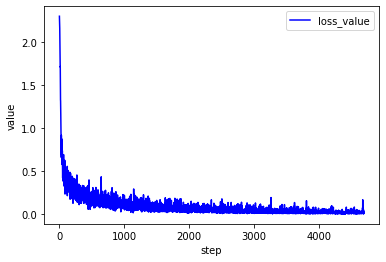

In [ ]:
import torch
# from utils import mini_batch, batch, download_mnist, get_torch_initialization, one_hot, plot_curve


class TorchModel:
    
    def __init__(self):
        self.W1 = torch.randn((28 * 28, 256), requires_grad=True)
        self.W2 = torch.randn((256, 64), requires_grad=True)
        self.W3 = torch.randn((64, 10), requires_grad=True)
        self.softmax_input = None
        self.log_input = None
    
    def forward(self, x):
        x = x.reshape(-1, 28 * 28)
        x = torch.relu(torch.matmul(x, self.W1))
        x = torch.relu(torch.matmul(x, self.W2))
        x = torch.matmul(x, self.W3)
        
        self.softmax_input = x
        self.softmax_input.retain_grad()
        
        x = torch.softmax(x, 1)
        
        self.log_input = x
        self.log_input.retain_grad()
        
        x = torch.log(x)
        
        return x
    
    def optimize(self, learning_rate):
        with torch.no_grad():
            self.W1 -= learning_rate * self.W1.grad
            self.W2 -= learning_rate * self.W2.grad
            self.W3 -= learning_rate * self.W3.grad
            
            self.W1.grad = None
            self.W2.grad = None
            self.W3.grad = None


def torch_run():
    train_dataset, test_dataset = download_mnist()
    
    model = TorchModel()
    model.W1.data, model.W2.data, model.W3.data = get_torch_initialization(numpy=False)
    
    train_loss = []
    
    epoch_number = 10
    learning_rate = 0.1
    
    for epoch in range(epoch_number):
        for x, y in mini_batch(train_dataset, numpy=False):
            y = one_hot(y, numpy=False)
            
            y_pred = model.forward(x)
            loss = (-y_pred * y).sum(dim=1).mean()
            loss.backward()
            model.optimize(learning_rate)
            
            train_loss.append(loss.item())
        
        x, y = batch(test_dataset, numpy=False)[0]
        accuracy = model.forward(x).argmax(dim=1).eq(y).float().mean().item()
        print('[{}] Accuracy: {:.4f}'.format(epoch, accuracy))
    
    plot_curve(train_loss)


if __name__ == "__main__":
    torch_run()